# NYC Building Energy Benchmarking

In [1]:
import xgboost as xgb
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sb
import matplotlib.pyplot as plt

import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import confusion_matrix
import matplotlib.mlab as mlab
%matplotlib inline

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

import os
#print(os.listdir("../input"))

In [2]:
def showCorr(df):
    fig = plt.subplots(figsize = (10,10))
    sb.set(font_scale=1.5)
    sb.heatmap(df.corr(),square = True,cbar=True,annot=True,annot_kws={'size': 10})
    plt.show()

In [3]:
treino_base = pd.read_csv('../input/dataset_treino.csv')
treino = treino_base.copy()
treino.describe().T

,count,mean,std,min,25%,50%,75%,max
Order,6622.0,7.420260e+03,4.220064e+03,21.000000,3.695250e+03,7.374500e+03,1.116500e+04,1.499300e+04
Property Id,6622.0,3.649956e+06,1.044968e+06,7365.000000,2.769788e+06,3.324127e+06,4.409690e+06,5.990844e+06
DOF Gross Floor Area,6590.0,1.611635e+05,2.569749e+05,50028.000000,6.519200e+04,9.161600e+04,1.551560e+05,8.512479e+06
Largest Property Use Type - Gross Floor Area (ft²),6622.0,1.547783e+05,2.340884e+05,3800.000000,6.600000e+04,9.100000e+04,1.514815e+05,6.940450e+06
Year Built,6622.0,1.948318e+03,2.988505e+01,1649.000000,1.927000e+03,1.940000e+03,1.964000e+03,2.019000e+03
Number of Buildings - Self-reported,6622.0,1.285563e+00,3.892317e+00,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.400000e+02
Occupancy,6622.0,9.901767e+01,5.666364e+00,0.000000,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
ENERGY STAR Score,6622.0,6.047735e+01,2.944029e+01,1.000000,3.800000e+01,6.600000e+01,8.600000e+01,1.000000e+02
Site EUI (kBtu/ft²),6622.0,8.012235e+01,3.201307e+01,0.000000,6.270000e+01,7.850000e+01,9.590000e+01,2.048000e+02
Property GFA - Self-Reported (ft²),6622.0,1.598433e+05,2.439364e+05,120.000000,6.700000e+04,9.299800e+04,1.554812e+05,6.940450e+06


In [4]:
teste_base = pd.read_csv('../input/dataset_teste.csv')
teste = teste_base.copy()
teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2839 entries, 0 to 2838
Data columns (total 59 columns):
OrderId                                                       2839 non-null int64
Property Id                                                   2839 non-null int64
Property Name                                                 2839 non-null object
Parent Property Id                                            2839 non-null object
Parent Property Name                                          2839 non-null object
BBL - 10 digits                                               2837 non-null object
NYC Borough, Block and Lot (BBL) self-reported                2839 non-null object
NYC Building Identification Number (BIN)                      2839 non-null object
Address 1 (self-reported)                                     2839 non-null object
Address 2                                                     2839 non-null object
Postal Code                                                   283

In [5]:
treino.head()

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2,Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
0,21,2780056,720-730 Ft. Washington Owners Corp.,2780056,720-730 Ft. Washington Owners Corp.,1021800614;1021800628,1021800614;1021800628,1064475;1064476;1803806,720-730 Ft. Washington Ave.,Not Available,10040,NaN,NaN,NaN,NaN,Multifamily Housing,Multifamily Housing,Multifamily Housing,321464.0,Not Available,Not Available,Not Available,Not Available,1939,2,100,Whole Building,Whole Building,72,76.2,79.9,3.5,0,106.2,Not Available,Not Available,1.96354077E7,Not Available,Not Available,Not Available,880200,8906.3,3968641.7,1121931.8,1893.4,1525.1,368.3,321464,5915.6,18.4,103.3,05/01/2017 10:09:31 PM,Yes,In Compliance,NaN,NaN,NaN,NaN,NaN,NaN
1,22,4988574,- 720 Ft. Washington Ave. bldg,2780056,720-730 Ft. Washington Owners Corp.,1021800614,1021800614,1064475,720-730 Ft. Washington Ave.,Not Available,10040,720,FT WASHINGTON AVENUE,Manhattan,179130.0,Multifamily Housing,Multifamily Housing,Multifamily Housing,204720.0,Not Available,Not Available,Not Available,Not Available,1939,1,100,Whole Building,Not Available,67,75.7,79,4,0,109.1,Not Available,Not Available,1.20478901E7,Not Available,Not Available,Not Available,553439.4,5604.4,2886852.2,820016.2,1204.4,936.5,267.9,204720,Not Available,Not Available,106.6,05/01/2017 10:09:31 PM,NaN,In Compliance,40.857943,-73.934962,12.0,10.0,281.0,Washington Heights North ...
2,24,2806486,Park 76th Street Inc.,2806486,Park 76th Street Inc.,1013900037;1013910034,1013900037;1013910034,1041702; 1041800,830-840 Park Avenue,Not Available,10021,NaN,NaN,NaN,NaN,Multifamily Housing,Multifamily Housing,Multifamily Housing,189766.0,Not Available,Not Available,Not Available,Not Available,1911,2,100,Whole Building,Whole Building,100,68.0,Not Available,6.1,0.5,Not Available,Not Available,112138.8,Not Available,Not Available,Not Available,Not Available,8786386.9,98264.5,4013954.9,1156269.9,847.5,475,372.5,189766,Not Available,Not Available,115.6,05/01/2017 10:09:31 PM,Yes,In Compliance,NaN,NaN,NaN,NaN,NaN,NaN
3,25,4988686,- 830 Park Avenue bldg,2806486,Park 76th Street Inc.,1013900037,1013900037,1041702,830 Park Avenue,Not Available,10021,830,PARK AVENUE,Manhattan,151666.0,Multifamily Housing,Multifamily Housing,Multifamily Housing,130629.0,Not Available,Not Available,Not Available,Not Available,1911,1,100,Another configuration,Not Available,100,23.7,23.4,6.8,Not Available,73.3,Not Available,Not Available,Not Availa

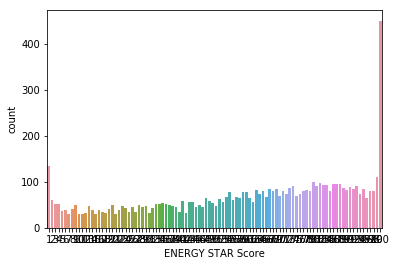

In [6]:
sb.countplot(x='ENERGY STAR Score',data=treino)

In [7]:
featuresTeste = [
    "Postal Code",
    "Latitude",
    "Longitude",
    "DOF Gross Floor Area",
    "Year Built",
    "Number of Buildings - Self-reported",
    "Occupancy",
    "Site EUI (kBtu/ft²)",
    "Property GFA - Self-Reported (ft²)",
    "Source EUI (kBtu/ft²)",
    "Community Board",
    "Council District",
    "Census Tract",
    "Weather Normalized Site EUI (kBtu/ft²)",
    "Weather Normalized Site Electricity Intensity (kWh/ft²)",
    "Weather Normalized Source EUI (kBtu/ft²)",
    "Weather Normalized Site Natural Gas Use (therms)",
    "Weather Normalized Site Electricity (kWh)",
    "Water Use (All Water Sources) (kgal)",
    "Water Intensity (All Water Sources) (gal/ft²)",
    "Total GHG Emissions (Metric Tons CO2e)",    
    "Direct GHG Emissions (Metric Tons CO2e)",
    "Indirect GHG Emissions (Metric Tons CO2e)",
    "Electricity Use - Grid Purchase (kBtu)",
    "Natural Gas Use (kBtu)",
    "Manhattan", "Queens", "Brooklyn", "Staten Island"]

featuresTreino = featuresTeste + ["ENERGY STAR Score"]

In [8]:
def setCity(df):
    lista = df["Borough"].value_counts()
    for item in lista.index:
        df[item] = df["Borough"] == item
        df[item] = df[item].astype(int)
    return df

In [9]:
def setPostalCode(df):
    df["Postal Code"] = df["Postal Code"].str.replace("-", "")
    df["Postal Code"] = df["Postal Code"].astype(int)  
    return df

In [10]:
def setMean(df, features):
    df = df.replace('Not Available',np.nan, regex=True)
    for item in features:
        if df[item].dtype == "object":
            df[item] = df[item].astype(float)

    for item in features:
        df[item] = df[item].fillna(df[item].mean())        
    
    return df

In [11]:
def setGeneralData(df, features):    
    df["Number of Buildings - Self-reported"][df["Number of Buildings - Self-reported"] > 30 ] = 30
    df["Number of Buildings - Self-reported"][df["Number of Buildings - Self-reported"] <= 0] = 1
    df["Occupancy"][df["Occupancy"] <= 0] = 1
    df["Site EUI (kBtu/ft²)"][df["Site EUI (kBtu/ft²)"] <= 0] = 1
    df["Property GFA - Self-Reported (ft²)"][df["Property GFA - Self-Reported (ft²)"] >= 2500000] = 2500000
    df["Source EUI (kBtu/ft²)"][df["Source EUI (kBtu/ft²)"] < 1] = 1
    df["Year Built"][df["Year Built"] < 1800] = 1800
    df["Year Built"][df["Year Built"] > 2015] = 2015    
    df = df.round(2)
    
    return df

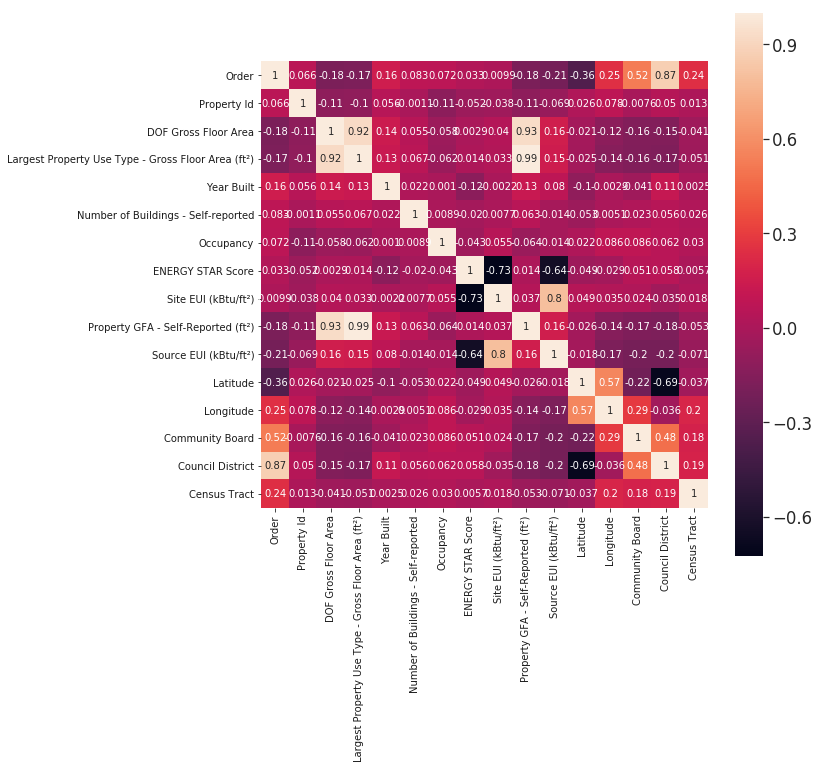

In [12]:
showCorr(treino)

In [13]:
treino.head()

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2,Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
0,21,2780056,720-730 Ft. Washington Owners Corp.,2780056,720-730 Ft. Washington Owners Corp.,1021800614;1021800628,1021800614;1021800628,1064475;1064476;1803806,720-730 Ft. Washington Ave.,Not Available,10040,NaN,NaN,NaN,NaN,Multifamily Housing,Multifamily Housing,Multifamily Housing,321464.0,Not Available,Not Available,Not Available,Not Available,1939,2,100,Whole Building,Whole Building,72,76.2,79.9,3.5,0,106.2,Not Available,Not Available,1.96354077E7,Not Available,Not Available,Not Available,880200,8906.3,3968641.7,1121931.8,1893.4,1525.1,368.3,321464,5915.6,18.4,103.3,05/01/2017 10:09:31 PM,Yes,In Compliance,NaN,NaN,NaN,NaN,NaN,NaN
1,22,4988574,- 720 Ft. Washington Ave. bldg,2780056,720-730 Ft. Washington Owners Corp.,1021800614,1021800614,1064475,720-730 Ft. Washington Ave.,Not Available,10040,720,FT WASHINGTON AVENUE,Manhattan,179130.0,Multifamily Housing,Multifamily Housing,Multifamily Housing,204720.0,Not Available,Not Available,Not Available,Not Available,1939,1,100,Whole Building,Not Available,67,75.7,79,4,0,109.1,Not Available,Not Available,1.20478901E7,Not Available,Not Available,Not Available,553439.4,5604.4,2886852.2,820016.2,1204.4,936.5,267.9,204720,Not Available,Not Available,106.6,05/01/2017 10:09:31 PM,NaN,In Compliance,40.857943,-73.934962,12.0,10.0,281.0,Washington Heights North ...
2,24,2806486,Park 76th Street Inc.,2806486,Park 76th Street Inc.,1013900037;1013910034,1013900037;1013910034,1041702; 1041800,830-840 Park Avenue,Not Available,10021,NaN,NaN,NaN,NaN,Multifamily Housing,Multifamily Housing,Multifamily Housing,189766.0,Not Available,Not Available,Not Available,Not Available,1911,2,100,Whole Building,Whole Building,100,68.0,Not Available,6.1,0.5,Not Available,Not Available,112138.8,Not Available,Not Available,Not Available,Not Available,8786386.9,98264.5,4013954.9,1156269.9,847.5,475,372.5,189766,Not Available,Not Available,115.6,05/01/2017 10:09:31 PM,Yes,In Compliance,NaN,NaN,NaN,NaN,NaN,NaN
3,25,4988686,- 830 Park Avenue bldg,2806486,Park 76th Street Inc.,1013900037,1013900037,1041702,830 Park Avenue,Not Available,10021,830,PARK AVENUE,Manhattan,151666.0,Multifamily Housing,Multifamily Housing,Multifamily Housing,130629.0,Not Available,Not Available,Not Available,Not Available,1911,1,100,Another configuration,Not Available,100,23.7,23.4,6.8,Not Available,73.3,Not Available,Not Available,Not Availa

(6622, 65)
(2839, 64)
(6622, 30)
(2839, 29)


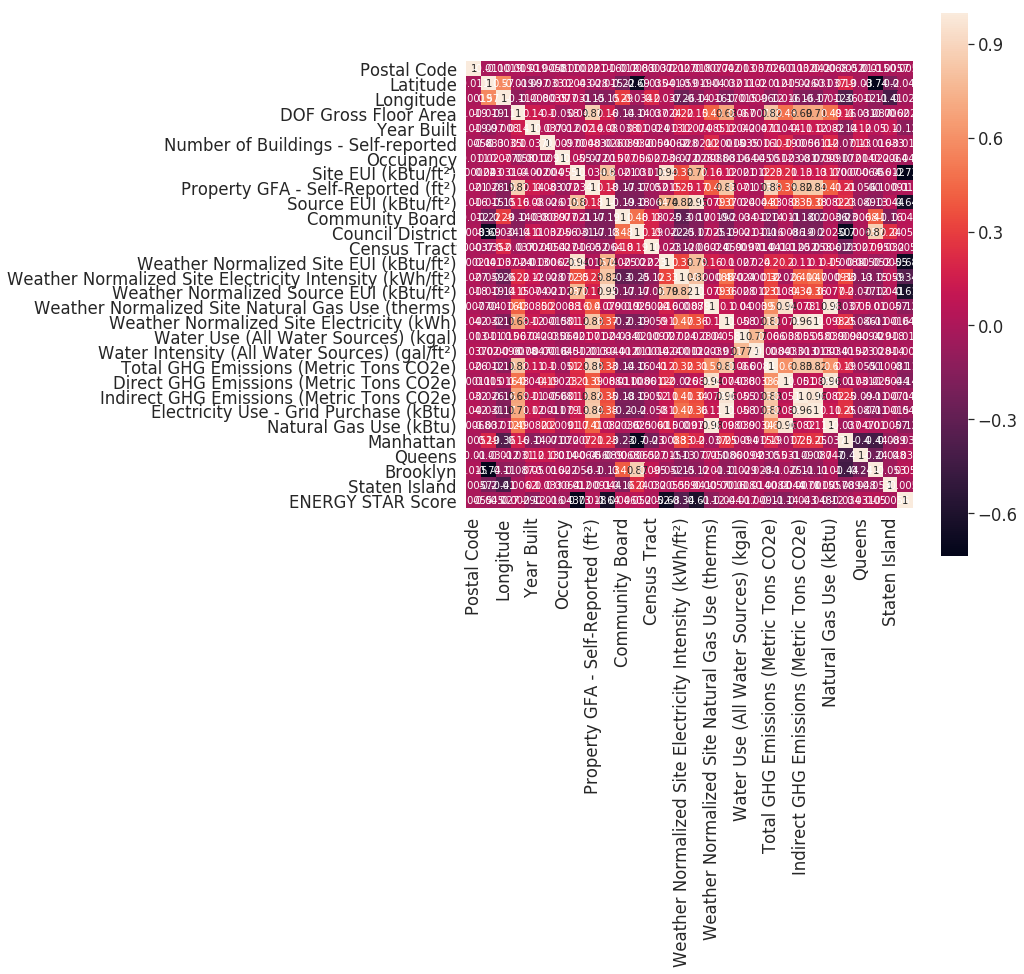

In [14]:
treino = setPostalCode(treino)
teste = setPostalCode(teste)

treino = setCity(treino)
teste = setCity(teste)

treino = setMean(treino, featuresTreino)
teste = setMean(teste, featuresTeste)

treino = setGeneralData(treino, featuresTreino)
teste = setGeneralData(teste, featuresTeste)

print(treino.shape)
print(teste.shape)
treino = treino.filter(items=featuresTreino)
teste = teste.filter(items=featuresTeste)
print(treino.shape)
print(teste.shape)

showCorr(treino)

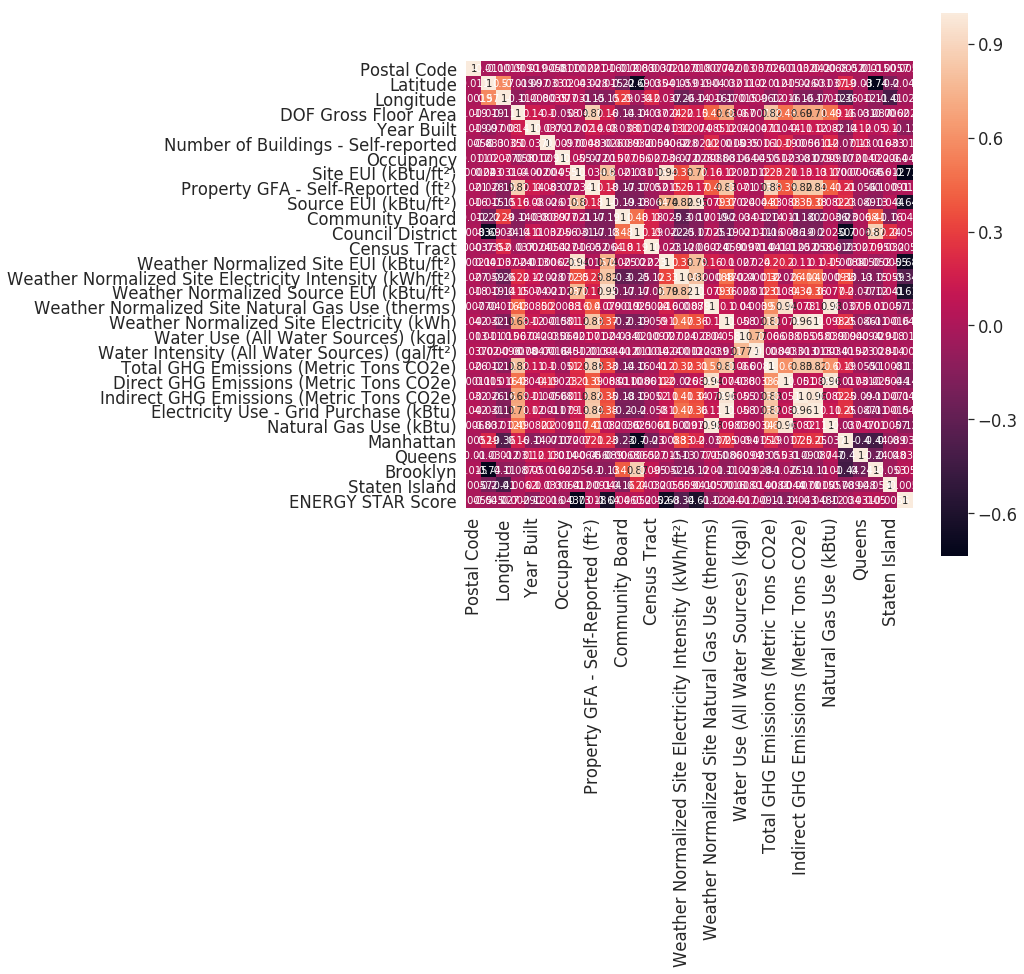

In [15]:
showCorr(treino)

In [16]:
treino.dtypes

Postal Code                                                  int64
Latitude                                                   float64
Longitude                                                  float64
DOF Gross Floor Area                                       float64
Year Built                                                   int64
Number of Buildings - Self-reported                          int64
Occupancy                                                    int64
Site EUI (kBtu/ft²)                                        float64
Property GFA - Self-Reported (ft²)                           int64
Source EUI (kBtu/ft²)                                      float64
Community Board                                            float64
Council District                                           float64
Census Tract                                               float64
Weather Normalized Site EUI (kBtu/ft²)                     float64
Weather Normalized Site Electricity Intensity (kWh/ft²)    flo

# Generete Model

In [17]:
X_train, X_test, y_train, y_test = train_test_split(treino.drop(columns=['ENERGY STAR Score']), pd.DataFrame(treino["ENERGY STAR Score"]))

In [18]:
finalModel = xgb.XGBClassifier(max_depth=10, learning_rate=0.1, n_estimators=1000, n_jobs=50)
finalModel

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=50, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [19]:
finalModel.fit(X_train, y_train, eval_metric='mae')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=50, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [20]:
y_pred = finalModel.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Mean squared error: 407.93
Variance score: 0.52


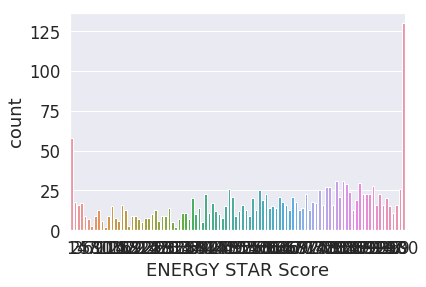

In [21]:
y_test['ENERGY STAR Score'] = finalModel.predict(X_test).round()
y_test.classe = y_test["ENERGY STAR Score"].astype(int)
sb.countplot(x='ENERGY STAR Score',data= y_test)

# Preparando Submission

In [22]:
teste.head()

,Postal Code,Latitude,Longitude,DOF Gross Floor Area,Year Built,Number of Buildings - Self-reported,Occupancy,Site EUI (kBtu/ft²),Property GFA - Self-Reported (ft²),Source EUI (kBtu/ft²),Community Board,Council District,Census Tract,Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Source EUI (kBtu/ft²),Weather Normalized Site Natural Gas Use (therms),Weather Normalized Site Electricity (kWh),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Electricity Use - Grid Purchase (kBtu),Natural Gas Use (kBtu),Manhattan,Queens,Brooklyn,Staten Island
0,11201,40.75,-73.96,166702.5,1903,2,100,32.0,432503,87.9,7.29,16.64,5481.33,83.41,7.5,137.26,20472.0,3249755.2,22061.00,51.01,1194.0,150.8,1043.2,11241926.1,2047200.0,0,0,0,0
1,10040,40.86,-73.93,102150.0,1939,1,100,77.1,116744,97.7,12.00,10.00,281.00,82.70,2.6,102.80,3301.9,308074.6,13320.55,89.66,689.0,588.6,100.4,1081789.4,326760.6,1,0,0,0
2,11427,40.75,-73.96,167856.0,1952,4,100,49.5,152308,105.5,7.29,16.64,5481.33,50.70,7.4,105.70,38952.7,1121175.7,13320.55,89.66,555.1,193.1,362.0,3900932.9,3634699.8,0,1,0,0
3,11427,40.75,-73.96,145056.0,1952,4,100,65.3,152380,158.2,7.29,16.64,5481.33,66.80,12.4,158.70,37194.6,1892619.8,13320.55,89.66,787.9,181.8,606.1,6531693.6,3422100.0,0,1,0,0
4,10027,40.75,-73.96,166702.5,1996,1,100,1.0,83131,1.0,7.29,16.64,5481.33,0.00,0.0,0.00,0.0,0.0,975.60,11.74,0.0,0.0,0.0,0.0,0.0,0,0,0,0


,count,mean,std,min,25%,50%,75%,max
Property Id,2839.0,3.655341e+06,1.049141e+06,8841.0,2772414.5,3296567.0,4409065.0,5991312.0
score,2839.0,6.030821e+01,3.074240e+01,1.0,36.0,67.0,87.0,100.0


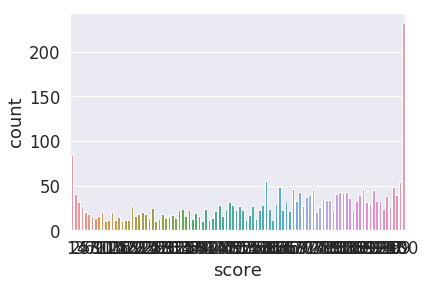

In [23]:
envio_final = pd.DataFrame(teste_base["Property Id"])
envio_final['score'] = finalModel.predict(teste).round()
envio_final['score'] = envio_final["score"].astype(int)
sb.countplot(x='score',data=envio_final)
envio_final.describe().T

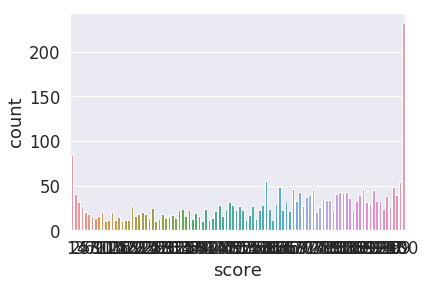

In [24]:
envio_final.score[envio_final.score < 1] = 1
envio_final.score[envio_final.score > 100] = 100
sb.countplot(x='score',data=envio_final)

In [25]:
envio_final.to_csv('final.csv', index=False)